# E-commerce customer segmentation

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [23]:
dfa = pd.read_csv('data (1).csv',encoding= 'unicode_escape')

dfa.shape

(541909, 8)

In [24]:
dfa.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Removing duplicate entries.


In [25]:
print('Duplicate entries: {}'.format(dfa.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((dfa.duplicated().sum()/dfa.shape[0])*100),2))
dfa.drop_duplicates(inplace = True)

Duplicate entries: 5268
1% rows are duplicate.


Checking the total number of products, transactions and customers.

In [26]:
pd.DataFrame([{'products': len(dfa['StockCode'].value_counts()),    
               'transactions': len(dfa['InvoiceNo'].value_counts()),
               'customers': len(dfa['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


Punctuation removal

In [27]:
dfa['Description']

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905           CHILDREN'S APRON DOLLY GIRL 
541906          CHILDRENS CUTLERY DOLLY GIRL 
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908          BAKING SET 9 PIECE RETROSPOT 
Name: Description, Length: 536641, dtype: object

In [28]:
df = pd.DataFrame(dfa['Description'].unique()).rename(columns = {0:'Desc_proc'})

In [29]:
df


,Desc_proc
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
4219,????damages????
4220,mixed up
4221,lost
4222,CREAM HANGING HEART T-LIGHT HOLDER


In [31]:
df['Desc_proc'] = df['Desc_proc'].str.replace("[^a-zA-Z0-9]", " ") #replace with space



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [32]:
df.head()

,Desc_proc
0,white hanging heart t light holder
1,white metal lantern
2,cream cupid hearts coat hanger
3,knitted union flag hot water bottle
4,red woolly hottie white heart


Replacing short words

In [33]:
df['Desc_proc'] = df['Desc_proc'].apply(lambda row: ' '.join([word for word in str(row).split() if len(word)>2]))

In [34]:
df['Desc_proc']

0          white hanging heart light holder
1                       white metal lantern
2            cream cupid hearts coat hanger
3       knitted union flag hot water bottle
4             red woolly hottie white heart
                       ...                 
4219                                damages
4220                                  mixed
4221                                   lost
4222       cream hanging heart light holder
4223              paper craft little birdie
Name: Desc_proc, Length: 4224, dtype: object

LowerCase character

In [35]:
df['Desc_proc'] = [x.lower() for x in df['Desc_proc']]
df['Desc_proc']

0          white hanging heart light holder
1                       white metal lantern
2            cream cupid hearts coat hanger
3       knitted union flag hot water bottle
4             red woolly hottie white heart
                       ...                 
4219                                damages
4220                                  mixed
4221                                   lost
4222       cream hanging heart light holder
4223              paper craft little birdie
Name: Desc_proc, Length: 4224, dtype: object

Remove stop words

In [36]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
stop_words = stopwords.words('english')

add_words = ['set','red','vintage','pink','jumbo','white','blue','small']
stop_words.extend(add_words)


def remove_stopwords(rev):
    review_tokenized = word_tokenize(rev)
    rev_new = " ".join([i for i in review_tokenized  if i not in stop_words])
    return rev_new
df['Desc_proc'] = [remove_stopwords(r) for r in df['Desc_proc']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
df['Desc_proc']

0                hanging heart light holder
1                             metal lantern
2            cream cupid hearts coat hanger
3       knitted union flag hot water bottle
4                       woolly hottie heart
                       ...                 
4219                                damages
4220                                  mixed
4221                                   lost
4222       cream hanging heart light holder
4223              paper craft little birdie
Name: Desc_proc, Length: 4224, dtype: object

Lemmatization

In [38]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
  nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
  wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
  lemmatized_sentence = []
  for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
  return " ".join(lemmatized_sentence)

df['Desc_proc'] = df['Desc_proc'].apply(lambda x: lemmatize_sentence(x))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [39]:
df['Desc_proc']

0                hang heart light holder
1                          metal lantern
2          cream cupid heart coat hanger
3       knit union flag hot water bottle
4                    woolly hottie heart
                      ...               
4219                              damage
4220                               mixed
4221                                lose
4222       cream hang heart light holder
4223           paper craft little birdie
Name: Desc_proc, Length: 4224, dtype: object

In [40]:
df

,Desc_proc
0,hang heart light holder
1,metal lantern
2,cream cupid heart coat hanger
3,knit union flag hot water bottle
4,woolly hottie heart
...,...
4219,damage
4220,mixed
4221,lose
4222,cream hang heart light holder


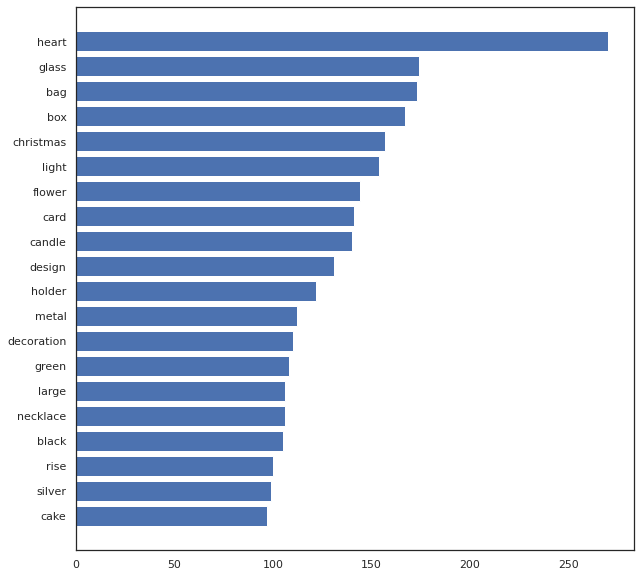

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white')
from nltk import FreqDist

all_words_df = df['Desc_proc']

all_words = ' '.join([text for text in all_words_df])
all_words = all_words.split()
words_df = FreqDist(all_words)

words_df = pd.DataFrame({'word':list(words_df.keys()), 'count':list(words_df.values())})
words_df
words_df = words_df.nlargest(columns="count", n = 20) 

words_df.sort_values('count', inplace = True)

# Plotting 30 frequent words
plt.figure(figsize=(10,10))
ax = plt.barh(words_df['word'], width = words_df['count'])
plt.show()

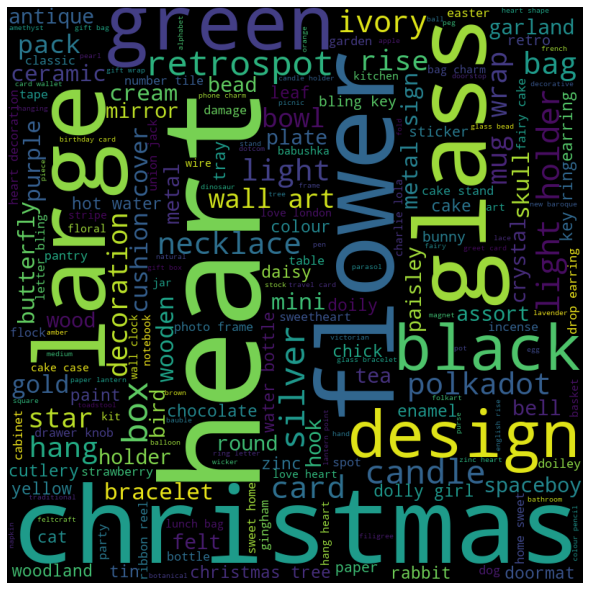

In [42]:
##
## Bilding a Word Cloud
## 
from wordcloud import WordCloud
word_cloud_df = df['Desc_proc']
all_words = ' '.join([text for text in word_cloud_df])
 

wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='black', 
                      min_font_size = 10).generate(all_words)

#plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Bag of Words Model

In [78]:
# Importing module
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X= vectorizer.fit_transform(df['Desc_proc'])
print(vectorizer.get_feature_names_out())




['100' '120cm' '125g' ... 'yuletide' 'zero' 'zinc']


In [79]:
df_bow= pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())
df_bow.head()

,100,120cm,125g,15c,15cm,16954,16955,16956,16957,16960,...,wreath,wreck,write,wrong,wrongly,xmas,yellow,yuletide,zero,zinc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


product categories

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = df["Desc_proc"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_IDF_matrix : (3843, 1796) of float64


In [97]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_IDF_embedded : (3843, 100) of float64


In [98]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

score_tfidf = []

x = list(range(5, 155, 10))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)

    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)

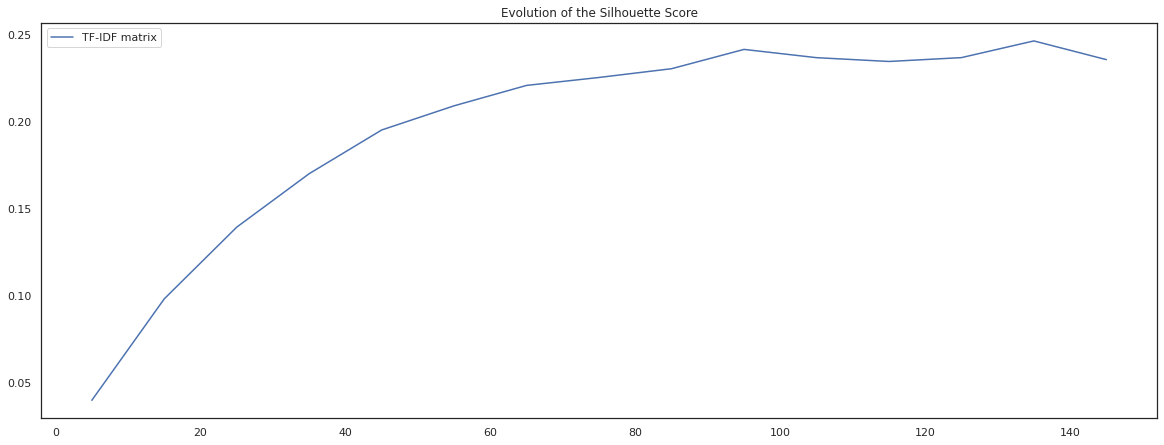

In [99]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

<Figure size 432x288 with 0 Axes>

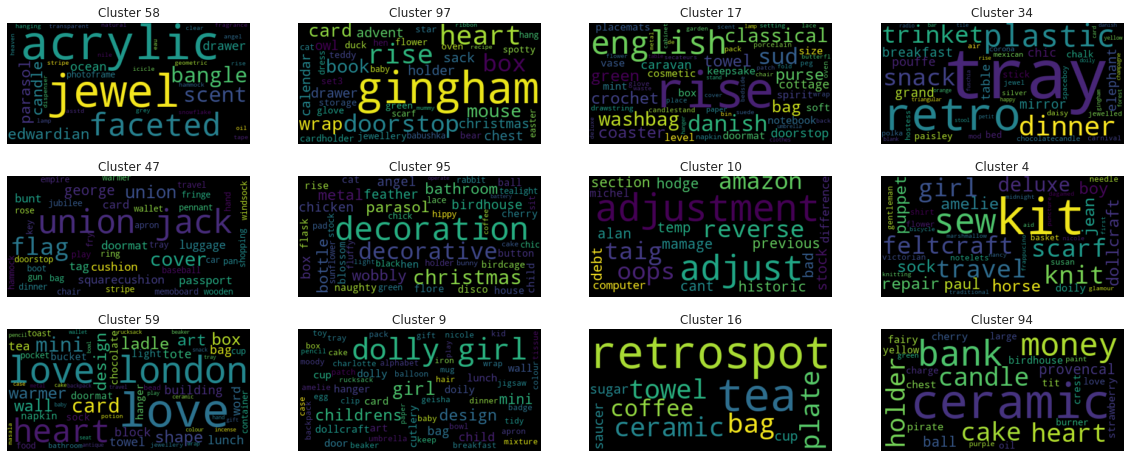

<Figure size 432x288 with 0 Axes>

In [100]:
plt.figure(figsize=(20,8))
wc = WordCloud()

for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()

In [103]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

Creating customer categories

In [112]:
df2_grouped_final = dfa.groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [114]:
df2_grouped_final

,Quantity,UnitPrice
CustomerID,,
12346.0,0.000000,1.000000
12347.0,0.836279,0.163721
12348.0,0.929075,0.070925
12349.0,0.510476,0.489524
12350.0,0.751048,0.248952
...,...,...
18280.0,0.485699,0.514301
18281.0,0.578406,0.421594
18282.0,0.609908,0.390092
